# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

#### Basic chatbot example using messages

In [4]:
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]

messages.append(
    HumanMessage(
        f"Yes, I know about whales. But what others should I learn about?", name="Lance"
    )
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
op = llm.invoke(messages)
pprint(op.content)

('There are several fascinating ocean mammals besides whales that you might '
 'find interesting to learn about. Here are a few:\n'
 '\n'
 '1. **Dolphins**: Known for their intelligence and playful behavior, dolphins '
 'are part of the cetacean family, which also includes whales. There are '
 'several species of dolphins, including the well-known bottlenose dolphin.\n'
 '\n'
 '2. **Porpoises**: Often confused with dolphins, porpoises are another group '
 'of marine mammals. They tend to be smaller and have shorter beaks compared '
 'to dolphins. \n'
 '\n'
 '3. **Seals**: These are pinnipeds, a group of marine mammals that include '
 'eared seals like sea lions and true seals like the harbor seal. They are '
 'known for their adaptability to both land and water environments.\n'
 '\n'
 '4. **Sea Lions**: Another type of pinniped, sea lions have external ear '
 'flaps and are more agile on land compared to true seals. They are social '
 'animals and often found in large groups.\n'
 '\n'


In [7]:
# Now we do this using graph
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

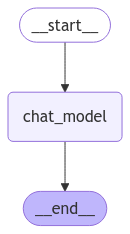

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might enjoy learning about:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are highly social animals often seen traveling in pods. There are many different species, including the bottlenose dolphin and the orca, which is technically a type of dolphin.

2. **Porpoises**: Similar in appearance to dolphins but generally smaller and with a more robust body, porpoises are less acrobatic than dolphins but equally interesting.

3. **Seals**: These semi-aquatic marine mammals are part of the pinniped family, which also incl

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

In [21]:
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import RemoveMessage

In [22]:
class MessagesState(MessagesState):
    pass


In [23]:
# Nodes
def filter_messages(state: MessagesState):
    """Filter messages to keep only the 2 most recent messages"""
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}


def chat_model_node(state: MessagesState):
    """Chat with the model"""
    return {"messages": [llm.invoke(state["messages"])]}

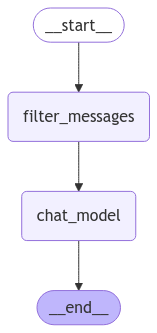

In [24]:
# Build graph: flow is now filter_messages -> chat_model
builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other interesting ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, known for their playful behavior and acrobatics. The bottlenose dolphin is the most familiar species.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different shaped teeth and fins. The Harbor porpoise is one common species.

3. **Seals

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

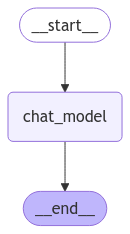

In [37]:
# Node
def chat_model_node(state: MessagesState):
    """Chat with the model using only the most recent message"""
    return {"messages": [llm.invoke(state["messages"][-1:])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Dolphins!", name="Lance"))
for i, m in enumerate(messages):
    print(f"Conversation {i}")
    m.pretty_print()

Conversation 0
================================== Ai Message ==================================
Name: Bot

Hi.
Conversation 1
================================ Human Message =================================
Name: Lance

Hi.
Conversation 2
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
Conversation 3
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
Conversation 4
================================== Ai Message ==================================

In addition to whales, there are several other interesting ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, known for their playful behavior and acrobatics. The bottlenose dolphin is the most familiar species.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different sh

In [39]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other interesting ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social animals, known for their playful behavior and acrobatics. The bottlenose dolphin is the most familiar species.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different shaped teeth and fins. The Harbor porpoise is one common species.

3. **Seals

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.
Trim messages to be below a token count.

trim_messages can be used to reduce the size of a chat history to a specified token count or specified message count.

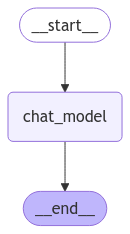

In [40]:
from langchain_core.messages import trim_messages


# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
messages.append(output["messages"][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({"messages": messages})

In [42]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='In addition to whales, there are several other interesting ocean mammals you might want to explore:\n\n1. **Dolphins**: Highly intelligent and social animals, known for their playful behavior and acrobatics. The bottlenose dolphin is the most familiar species.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different shaped teeth and fins. The Harbor porpoise is one common species.\n\n3. **Seals**: Aquatic mammals with a streamlined body and limbs